## STEP 1 - Accepted / Rejected Prediction

The first part of the project aims to automate LendingClub's lending decisions fully by creating a prediction model that can classify loans into accepted and rejected categories. This model will utilize data from LendingClub to make predictions about the likelihood of a loan being accepted or rejected.

* By implementing this model, LendingClub can **save money** and **reduce the need for manual underwriting**. The model can analyze large amounts of data quickly, streamlining the lending process and improving efficiency.
* Additionally, the model can reduce the risk of default by identifying potential borrowers who may not be able to repay their loans, allowing LendingClub to make more informed decisions about who to lend to and at what rates.

Overall, such machine learning model has the potential to transform LendingClub's lending process, making it more **accurate**, **efficient**, and **cost-effective**. By automating lending decisions and reducing the risk of default, LendingClub can improve their bottom line while also providing a better experience for borrowers.

#### Imports

In [1]:
import pandas as pd
import helpers 
import re
import warnings
import multiprocessing 
import lightgbm as lgb
from joblib import dump
  
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 

/Users/emabaranauskaite/Desktop/Turing/ebaran-ML1.3/lending_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings('ignore')

## Reading the data

In [3]:
''' Reading the datasets '''
df_accepted = pd.read_csv("lending-club/accepted.csv") 
df_rejected = pd.read_csv("lending-club/rejected.csv") 

In [4]:
''' Dropping duplicates from accepted and rejected datasets '''
df_accepted = df_accepted.drop_duplicates()
df_rejected = df_rejected.drop_duplicates()

In [5]:
''' Checking how many null values we have in the dataset '''
df_accepted.isnull().sum()

id                             0
member_id                2260701
loan_amnt                     33
funded_amnt                   33
funded_amnt_inv               33
                          ...   
settlement_status        2226455
settlement_date          2226455
settlement_amount        2226455
settlement_percentage    2226455
settlement_term          2226455
Length: 151, dtype: int64

## Prepare Data and Examining for Classification

#### Accepted and Rejected Loans Comparison

Since the two dataframes have different sets of features, I will need to select a subset of features that are present in both dataframes to build a loan approval prediction model. Some of the features might not be useful for prediction at all. Nevertheless, exploring these values will be useful. 

I will explore selected subset from both of the datasets. Selected features:

* **Amount Requested** in the rejected dataset and **loan_amnt** in the accepted dataset. This feature is present in both dataframes and could be an important predictor of loan approval.
* **State** in the rejected dataset and **addr_state** in the accepted dataset refer to the state where the borrower lives or works.
* **Debt-To-Income Ratio** in the rejected dataset and **dti** in the accepted dataset both measure the borrower's ability to pay back the loan by comparing their total debt payments to their income.
* **Employment Length** in the rejected dataset and **emp_length** in the accepted dataset both indicate how long the borrower has been employed.
* **Loan Title** in the rejected dataset and **purpose** in the accepted dataset.

In [6]:
''' Gathering all column columns from two datasets into one list '''
common_cols = ["loan_amnt", "addr_state", "dti", "emp_length", "purpose"]

It seems that policy_code value might be indicating the result of whether loan will be accepted or not. Thus this feature will not be used.

In [7]:
''' Checking whether loan policy is data leakage '''
print("Accepted Loans Policy Code:", *df_accepted['policy_code'].unique()) 
print("Rejected Loans Policy Code:", *df_rejected['Policy Code'].unique()) 

Accepted Loans Policy Code: 1.0 nan
Rejected Loans Policy Code: 0.0 2.0 nan


In [8]:
''' Converting the namings of columns to be the same for both datasets '''
df_rejected.columns = df_rejected.columns.str.replace('Amount Requested', 'loan_amnt') 
df_rejected.columns = df_rejected.columns.str.replace('State', 'addr_state') 
df_rejected.columns = df_rejected.columns.str.replace('Debt-To-Income Ratio', 'dti') 
df_rejected.columns = df_rejected.columns.str.replace('Employment Length', 'emp_length')  
df_rejected.columns = df_rejected.columns.str.replace('Loan Title', 'purpose') 

### Data Cleaning

Data cleaning is important because it ensures that the data used for analysis is accurate, reliable, and free from errors, inconsistencies, and inaccuracies, which helps to improve the quality of the analysis results.

In [9]:
''' Getting only the common columns from accepted dataset'''
df_accepted_step1 = df_accepted[common_cols].copy()

In [10]:
''' Checking what kind of missing values we have '''
df_accepted_step1.isnull().sum()

loan_amnt         33
addr_state        33
dti             1744
emp_length    146940
purpose           33
dtype: int64

The rows that are missing 'dti' value will be dropped, because we have 1806888 entries in the dataset, thus only 1744 values is not a huge loss.

In [11]:
''' Dropping missing values from dti column '''
df_accepted_step1 = df_accepted_step1[df_accepted_step1['dti'].isnull() == False]

We can now see that only employment length column has missing values

In [12]:
''' Checking for null values '''
df_accepted_step1.isnull().sum()

loan_amnt          0
addr_state         0
dti                0
emp_length    145309
purpose            0
dtype: int64

Now, I'll convert the dti (debt to income) value to percentage.

In [13]:
''' Checking current dti format'''
df_accepted_step1['dti'].head(3)

0     5.91
1    16.06
2    10.78
Name: dti, dtype: float64

In [14]:
''' Converting dti values into percentages'''
df_accepted_step1['dti'] = df_accepted_step1['dti'] / 100
df_accepted_step1['dti'].head(3)

0    0.0591
1    0.1606
2    0.1078
Name: dti, dtype: float64

#### Cleaning rejected loans dataset

First, I'll start to clean up the rejected loans dataset.

In [15]:
''' Creating new variable for rejected loans cleanup '''
df_rejected_step1 = df_rejected[common_cols].copy()

In [16]:
''' Checking what null values we have there '''
df_rejected_step1.isnull().sum()

loan_amnt          0
addr_state        22
dti                0
emp_length    949702
purpose         1283
dtype: int64

Since there is a small proportion of data missing from purpose column, I'll drop those values.

In [17]:
''' Dropping rows where purpose is missin '''
df_rejected_step1 = df_rejected_step1[(df_rejected_step1['purpose'].isnull() == False) & (df_rejected_step1['addr_state'].isnull() == False)]

Now we see that there is way less missing values in the dataset now. Only the column employment length has missing rows

In [18]:
''' Priting null values '''
df_rejected_step1.isnull().sum()

loan_amnt          0
addr_state         0
dti                0
emp_length    949702
purpose            0
dtype: int64

In [19]:
''' I'll convert dti into percentage as well '''
df_rejected_step1['dti'] = df_rejected_step1['dti'].str.rstrip('%').astype('float') / 100.0

### Exploratory data analysis

I'll analyse each value we have, their distributions and how it might influence the rejected or accepted choice

#### Loan Amount
The loan amount is determined based on factors such as creditworthiness, income, debt-to-income ratio and other variables.

We can see that there is quite a few outliers in rejected loans dataset.

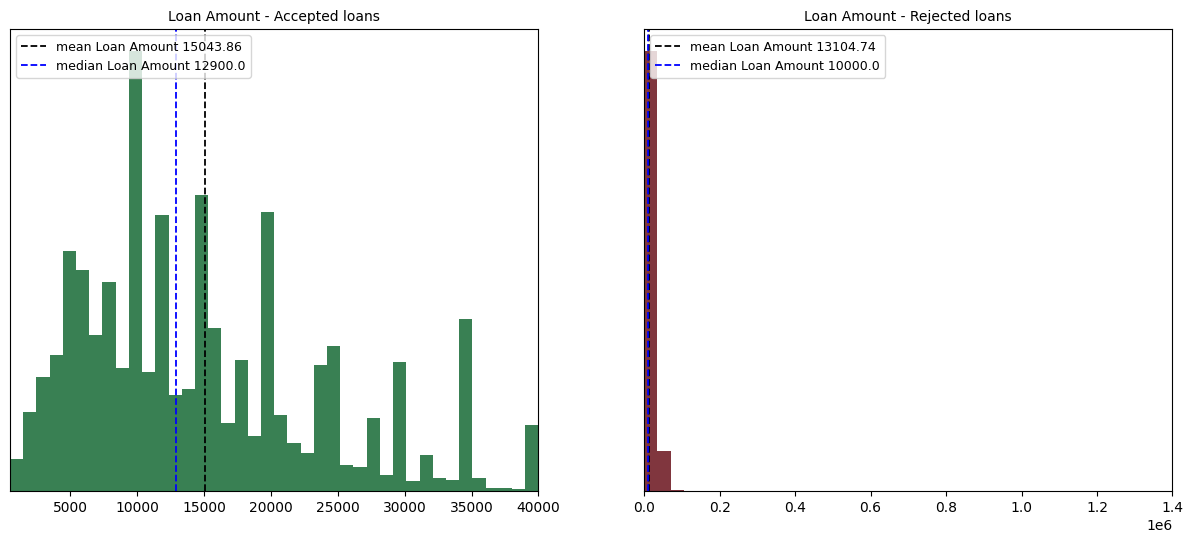

In [23]:
''' Plotting accepted and rejected loans distribution histograms '''
helpers.plot_histograms_accepted_rejected([df_accepted_step1, df_rejected_step1], "loan_amnt", "Loan Amount")

We can see the same in the box plots

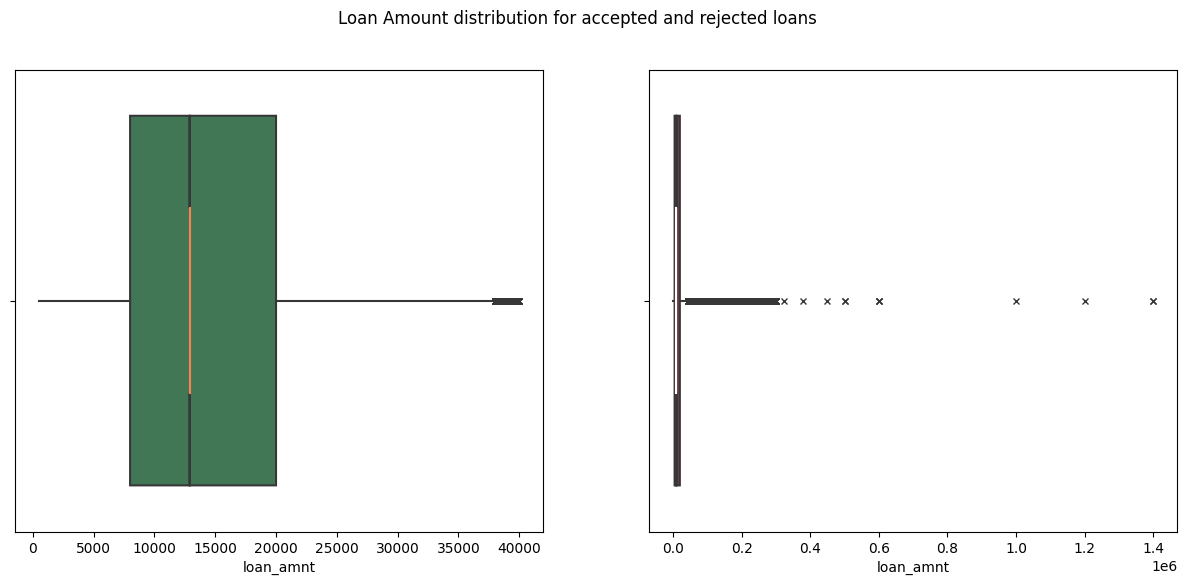

In [24]:
''' Plotting accepted and rejected loans distribution box plots ''' 
helpers.plot_box_plot_by_col(df_accepted_step1, df_rejected_step1, "loan_amnt", col_name="Loan Amount")

Since there is so much outliers, their removal is necessary for analysis.

The threshold for removing outliers 0.1 meaning that 10% of the dataset will be removed.

In [25]:
''' Removing the outliers from the dataset '''
df_rejected_no_outliers = helpers.remove_outliers_col(df_rejected_step1, "loan_amnt")

Now we can see way better results in the histograms and we can gather the insights about the data:

* The median loan amount for accepted loans (12900) is higher than rejected loans (10000)
* The mean loan amount for accepted loans (15043.86) is higher than rejected loans (10865.78)

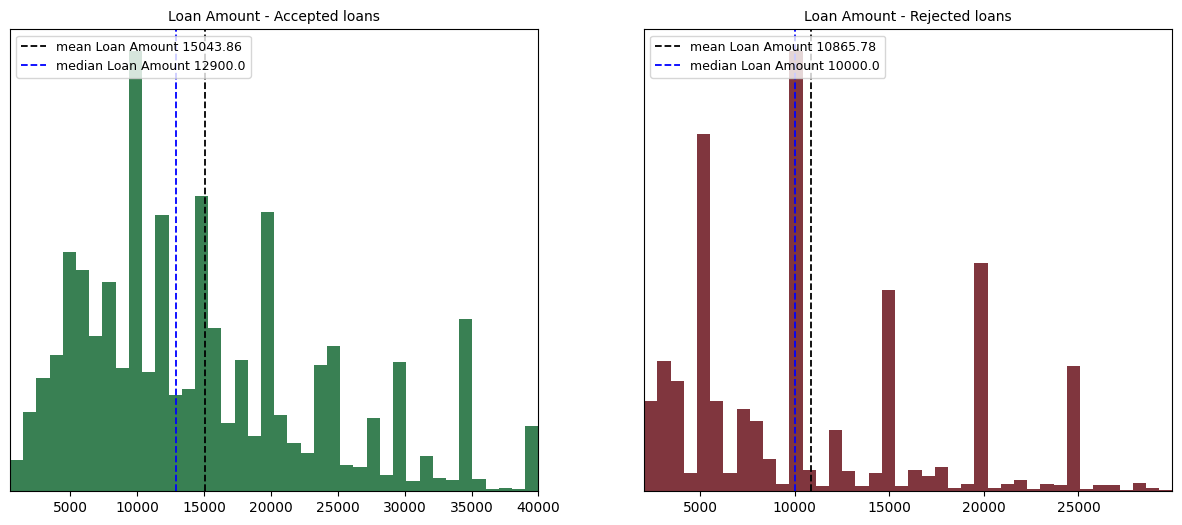

In [26]:
helpers.plot_histograms_accepted_rejected([df_accepted_step1, df_rejected_no_outliers], "loan_amnt", "Loan Amount")

We can see that the box plots are now more representable as well

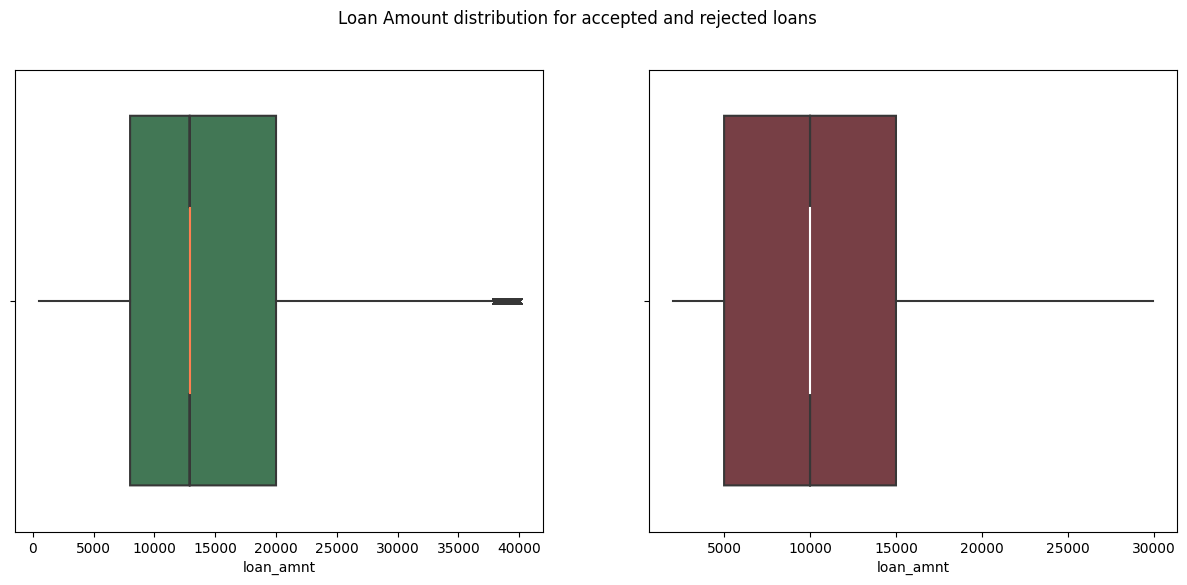

In [27]:
''' Plotting accepted and rejected loans distribution box plots ''' 
helpers.plot_box_plot_by_col(df_accepted_step1, df_rejected_no_outliers, "loan_amnt", col_name="Loan Amount")

In [28]:
''' Putting rejected loans into new variable without outliers in loan_amnt column'''
df_rejected_step1 = df_rejected_no_outliers.copy()

#### Debt-to-Income ratio
DTI stands for Debt-to-Income ratio, which is a financial metric that compares a person's monthly debt payments to their monthly gross income. It is calculated by dividing the total amount of monthly debt payments by the gross monthly income.

We can see that the DTI column has a lot of outliers. Thus in both accepted and rejected datasets they have to be removed.

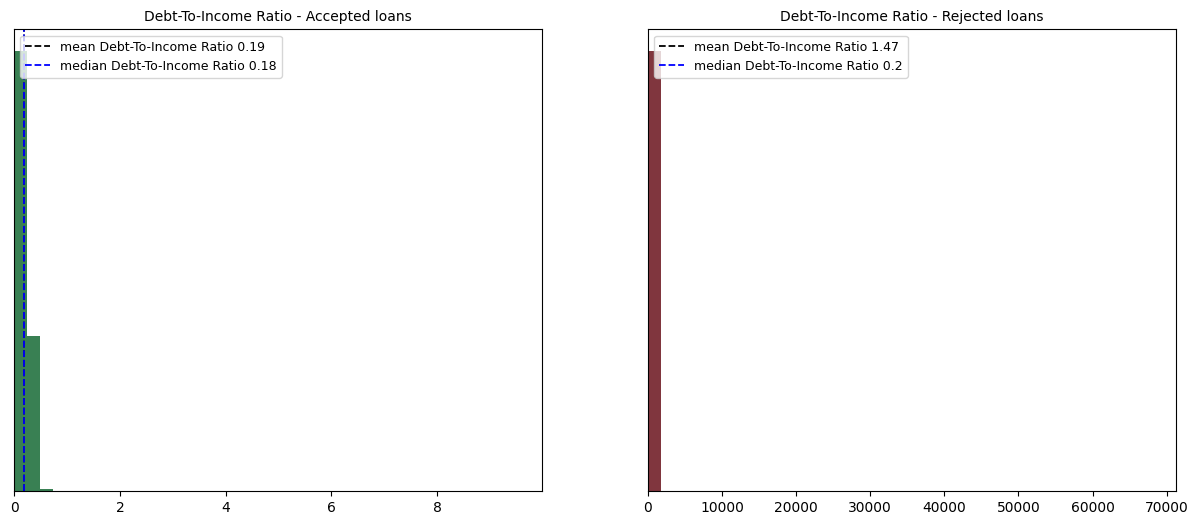

In [29]:
''' Plotting DTI histograms for accepted and rejected '''
helpers.plot_histograms_accepted_rejected([df_accepted_step1, df_rejected_step1], "dti", "Debt-To-Income Ratio")

Same results are in the box plots, thus the results are not informative

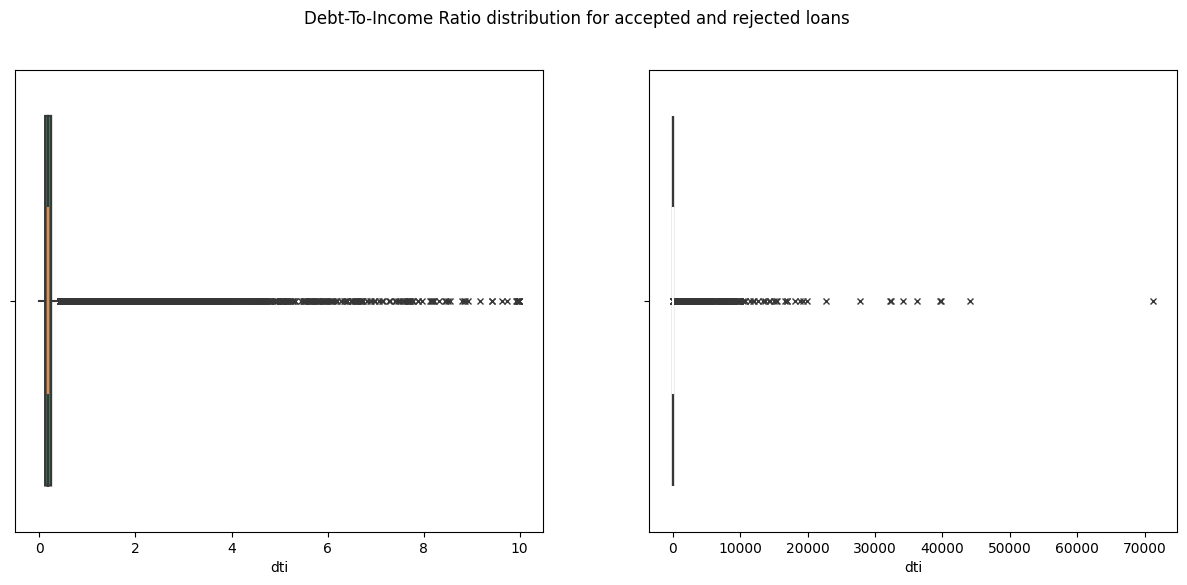

In [30]:
''' Plotting DTI box plots for accepted and rejected ''' 
helpers.plot_box_plot_by_col(df_accepted_step1, df_rejected_step1, "dti", "Debt-To-Income Ratio")

Now we can see better results after removing dti outliers

In [31]:
''' Removing outliers from accepted datasets '''
df_accepted_no_outliers = helpers.remove_outliers_col(df_accepted_step1, "dti")

In [32]:
''' Removing outliers from rejected datasets '''
df_rejected_no_outliers = helpers.remove_outliers_col(df_rejected_step1, "dti")

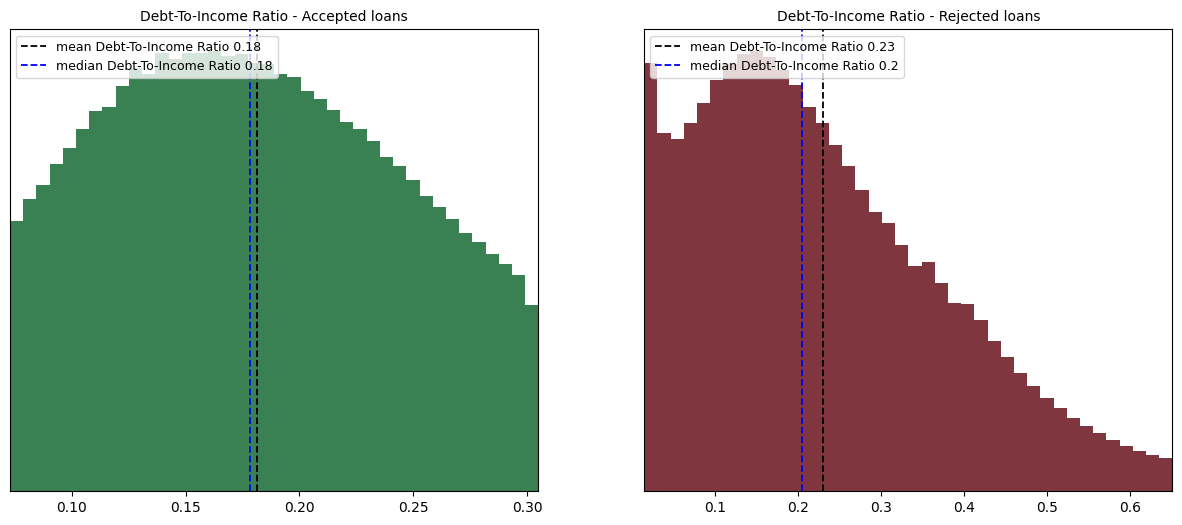

In [33]:
''' Plotting dti distribution histogram for accepted and rejected loans without dti outliers '''
helpers.plot_histograms_accepted_rejected([df_accepted_no_outliers, df_rejected_no_outliers], "dti", "Debt-To-Income Ratio")

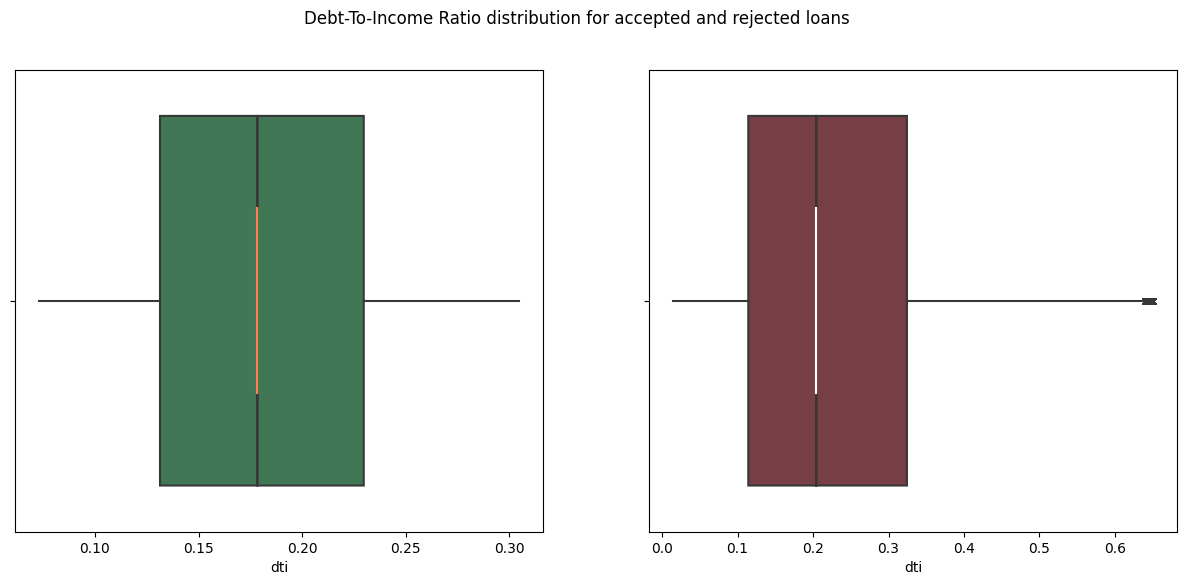

In [34]:
''' Plotting dti distribution histogram for accepted and rejected loans without dti outliers '''
helpers.plot_box_plot_by_col(df_accepted_no_outliers, df_rejected_no_outliers, "dti", "Debt-To-Income Ratio")

In [35]:
''' Initializing accepted/rejected variables with new without outliers data '''
df_accepted_step1 = df_accepted_no_outliers.copy()
df_rejected_step1 = df_rejected_no_outliers.copy()

#### Employment Length

Employment length can be represented as numerical values for it becoming ordinal column. So I'll do this for both of the datasets 

In [36]:
''' Map rejected loans employment lengths into ordinal numerical values '''
df_rejected_step1['emp_length'] = df_rejected_step1['emp_length'].map({"< 1 year": 0, "1 year": 1,
                                                                       "2 years": 2, "3 years": 3,
                                                                       "4 years": 4, "5 years": 5,
                                                                       "6 years": 6, "7 years": 7,
                                                                       "8 years": 8, "9 years": 9, "10+ years":10})

In [37]:
''' Map accepted loans employment lengths into ordinal numerical values '''
df_accepted_step1['emp_length'] = df_accepted_step1['emp_length'].map({"< 1 year": 0, "1 year": 1,
                                                                       "2 years": 2, "3 years": 3,
                                                                       "4 years": 4, "5 years": 5,
                                                                       "6 years": 6, "7 years": 7,
                                                                       "8 years": 8, "9 years": 9, "10+ years":10})

I also wanted to see the distributions of employment length between both accepted and rejected loans.

We can see that the biggest proportion of accepted loans had employment length of 10, while in rejected it has 0.

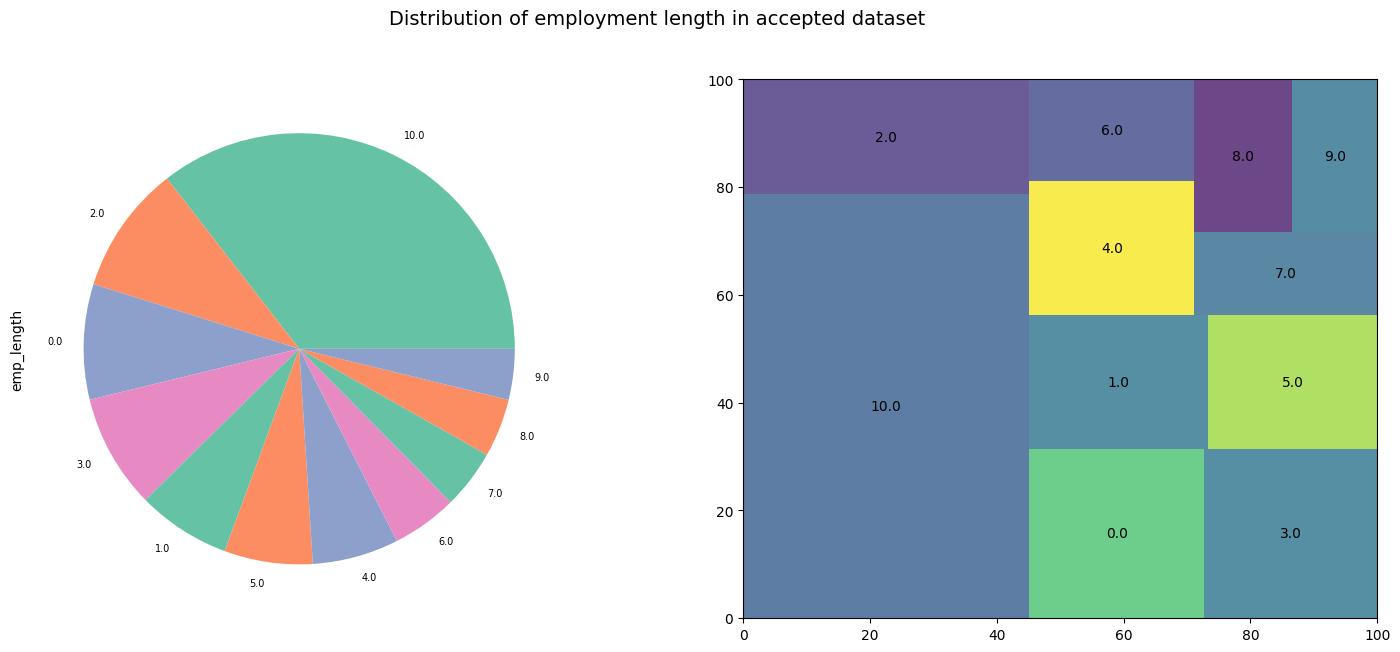

<Figure size 1500x800 with 0 Axes>

In [38]:
''' Plot employment length distribution in accepted loans '''
helpers.plot_pie_and_tree_plot(df_accepted_step1, "emp_length", 'accepted')

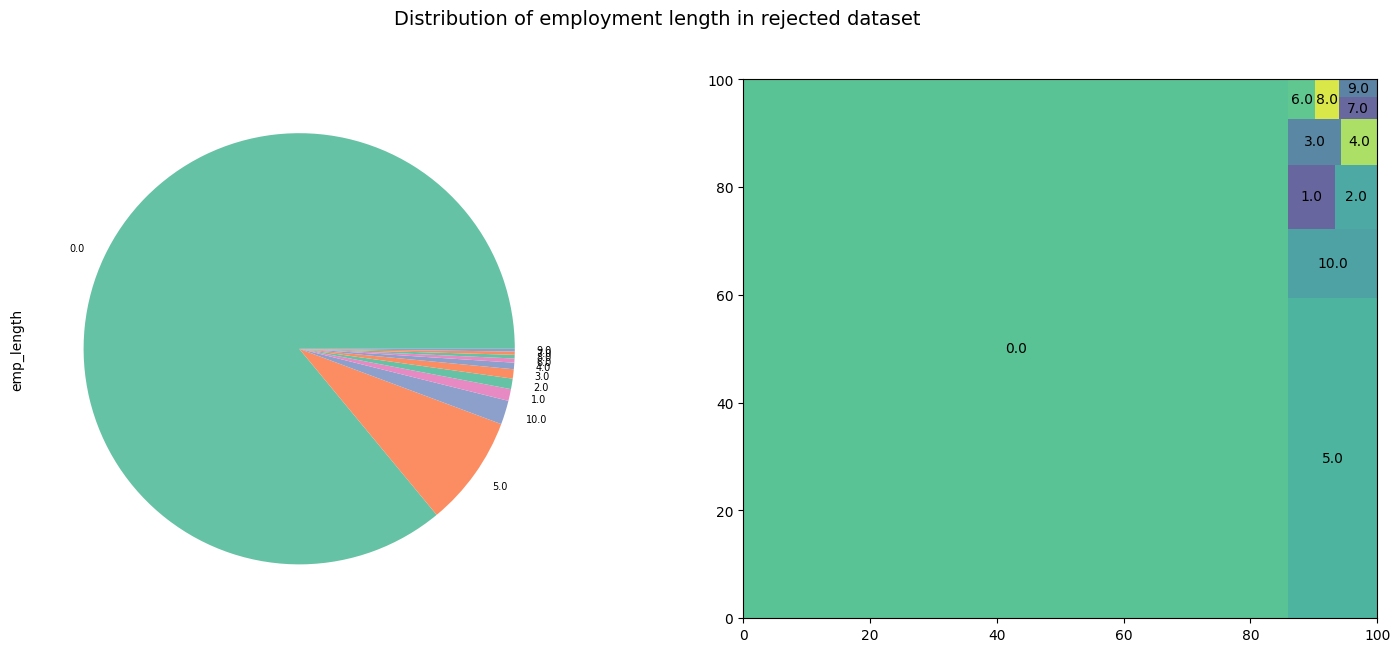

<Figure size 1500x800 with 0 Axes>

In [39]:
''' Plot employment length distribution in rejected loans '''
helpers.plot_pie_and_tree_plot(df_rejected_step1, "emp_length", 'rejected')

#### Address State

I wanted to see maybe state is important for loan acceptance. For these particular reasons:

* **Legal Requirements**: Different states have different laws and regulations related to lending and borrowing. Lenders may be required to follow different rules depending on the state where the borrower resides. For example, some states may have limits on the interest rates that lenders can charge, while others may require lenders to follow specific disclosure requirements.

* **Fraud Prevention**: Lenders may use address verification to prevent fraud by ensuring that the borrower's address is legitimate and matches their identity. Lenders may also use address verification to confirm that the borrower is not located in a state where lending is prohibited or restricted.

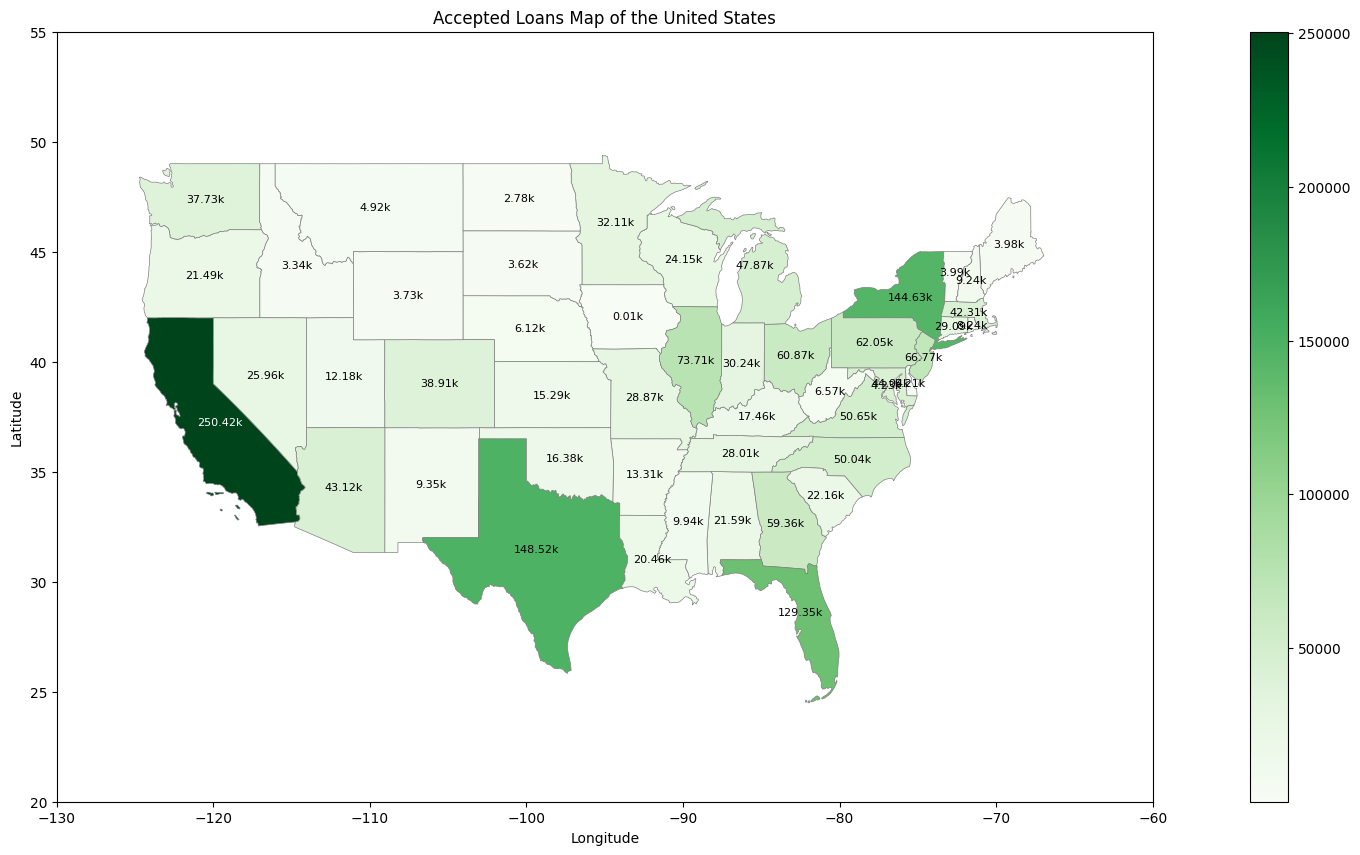

In [40]:
''' Plotting map of accepted loans address states '''
helpers.plot_addr_state_map(df_accepted_step1)  

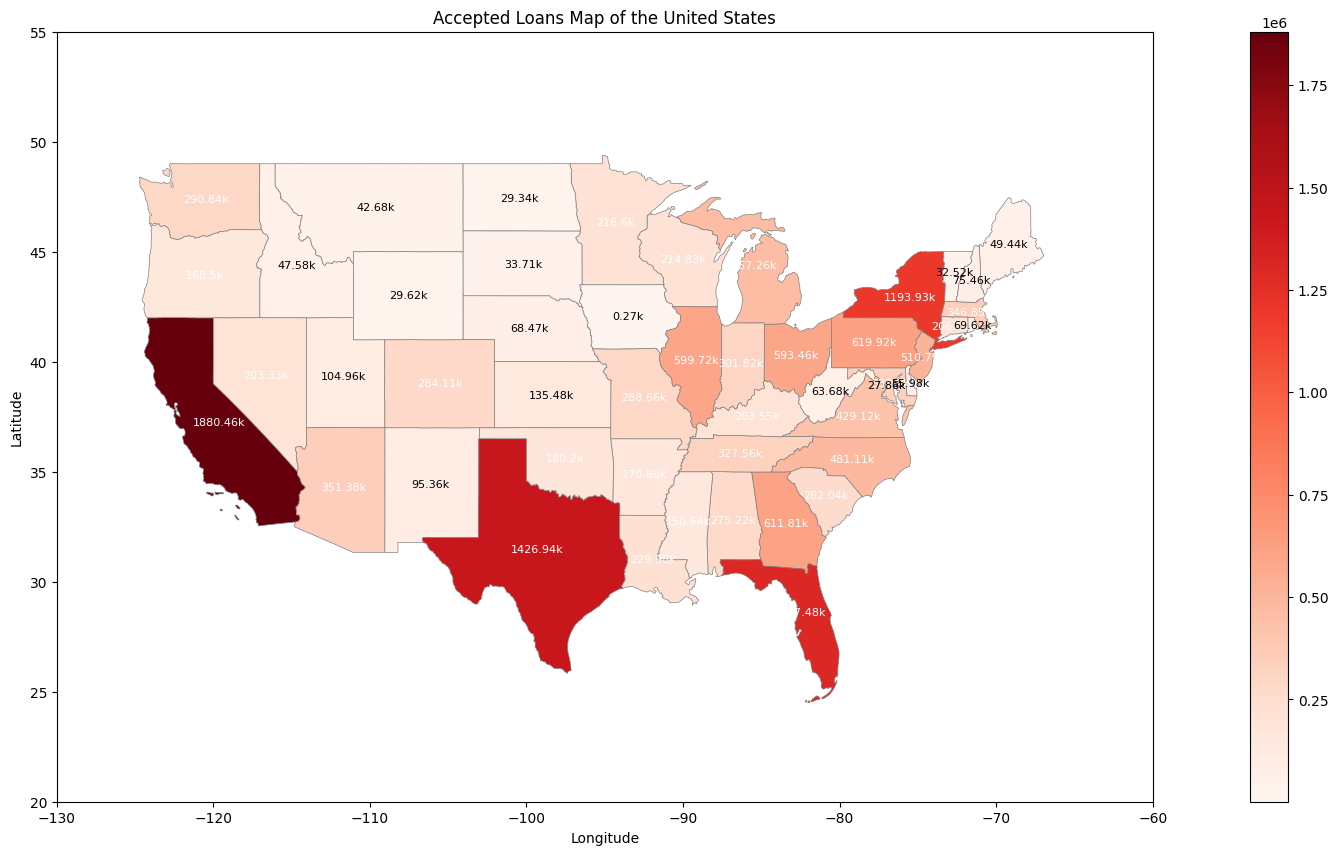

In [41]:
''' Plotting map of rejected loans address states '''
helpers.plot_addr_state_map(df_rejected_step1, 'Reds') 

We can see the same results in the bar plot below. The states distribution in the accepted and rejected columns do not differ much. We can see that the least popular state was Iowa. And the top 2 most popular states were **California** and **Texas**. Therefore, I would not say that state actually would play a very important role in this accepted/rejected prediction.

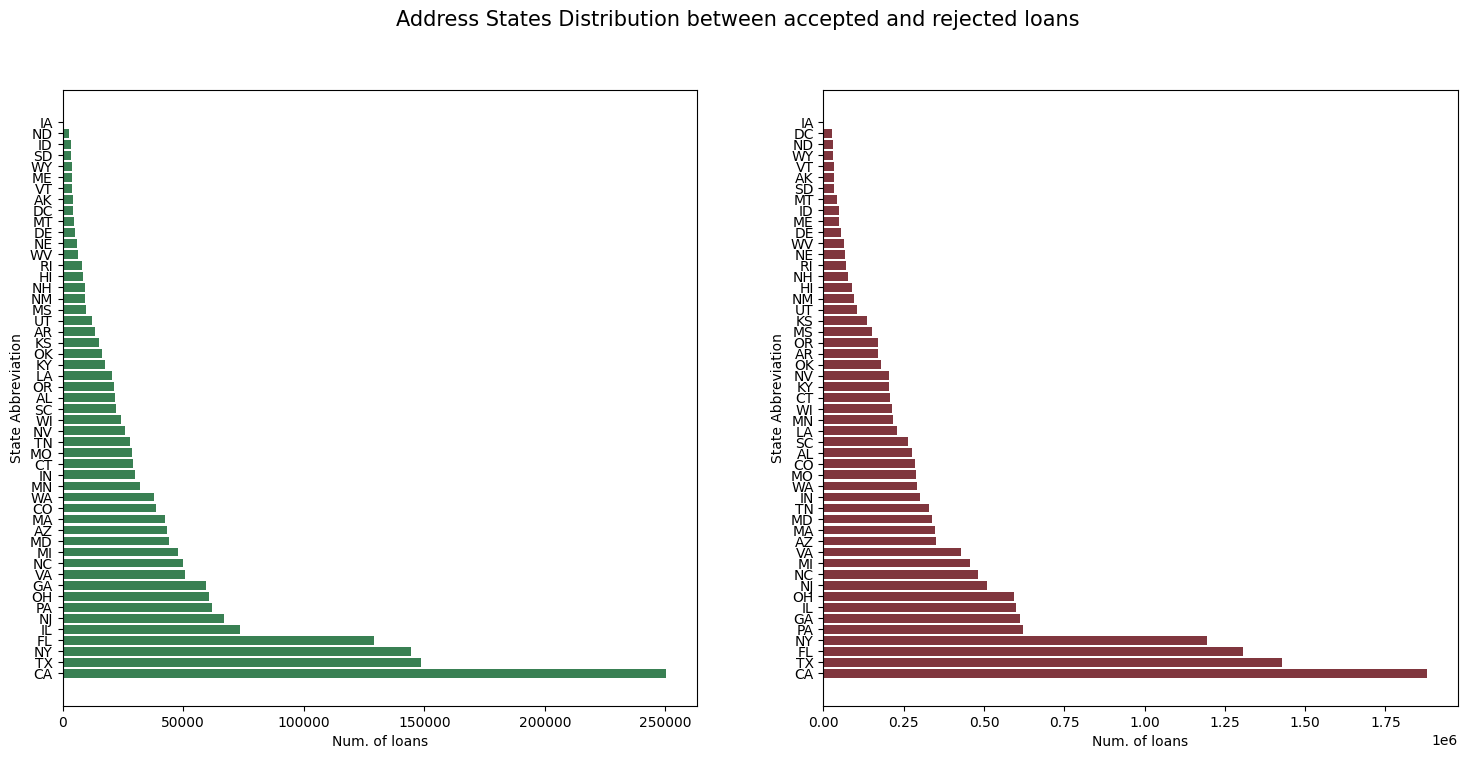

In [42]:
''' Plotting bar charts bar plots for address state distributions'''
helpers.plot_addr_state_bar_plots(df_accepted_step1, df_rejected_step1)

#### Purpose

The purpose variable in the loan dataset for Lending Club refers to the reason why the borrower is seeking a loan. This variable indicates the primary intended use of the funds borrowed by the borrower.

In the Lending Club dataset, the purpose variable has 14 unique values, including **debt consolidation**, **credit card refinancing**, **home improvement**, **major purchase**, **small business**, and **others**.

Lenders and investors use this information to evaluate the risk associated with each loan request and make an informed decision on whether to fund the loan or not.

##### Accepted Loans Purposes

First, I investigate the distribution of purpose in the accepted loan dataset. 

In [43]:
''' Taking variable for purpose examination'''
df_acc_purpose = df_accepted_step1.copy()

In [44]:
''' Printing purpose value counts '''
df_acc_purpose['purpose'].value_counts()

debt_consolidation    1038155
credit_card            421711
home_improvement       113373
other                  104809
major_purchase          36015
medical                 20846
small_business          17933
car                     17348
vacation                11920
moving                  11626
house                    9944
wedding                  1805
renewable_energy         1116
educational               287
Name: purpose, dtype: int64

First, I wanted to preprocess purpose variable a bit. Firstly, I made each purpose value lowercase, then removed puntuation.

In [45]:
''' Removing punctuation and lowercasing the purpose column in accepted dataset'''
df_acc_purpose['purpose'] = df_acc_purpose["purpose"].apply(lambda s: ' '.join(re.sub(r'[^a-zA-Z0-9]', " ", s).split()))
df_acc_purpose['purpose'] = df_acc_purpose['purpose'].str.lower()
df_acc_purpose['purpose'] = df_acc_purpose['purpose'].str.replace('[^\w\s]','') 

Then, I performed stemming with Snowball stemming.

In [46]:
''' Performing stemming of purpose value '''
with multiprocessing.Pool() as pool:
    df_acc_purpose['purpose'] = pool.map(helpers.stem, df_acc_purpose['purpose'])

We now see the preprocessed values

In [47]:
''' Displaying head of preprocessed purpose values '''
df_acc_purpose[['purpose']].head()

,purpose
1,small busi
2,home improv
3,debt consolid
4,major purchas
5,debt consolid


##### Rejected Loans Purposes

Since rejected dataset has a bit more "free text" purpose, I'll need to do more preprocessing on it.

In [48]:
''' Creating variable for rejected loans purpose analysis '''
df_rej_purpose = df_rejected_step1.copy()

We saw that in accepted loans there were only 14 unique values in accepted dataset but in rejected there are almost 50K unique values. I'll now try to convert those values into the ones found in the accepted dataset

In [49]:
''' Printing out the length of unique purpose values'''
len(df_rej_purpose['purpose'].unique())

49553

First, I start with preprocessing rejected loan purposes

In [50]:
''' Removing punctuation marks and making purpose lowercase '''
df_rej_purpose['purpose'] = df_rej_purpose["purpose"].apply(lambda s: ' '.join(re.sub(r'[^a-zA-Z0-9]', " ", s).split()))
df_rej_purpose['purpose'] = df_rej_purpose['purpose'].str.lower()
df_rej_purpose['purpose'] = df_rej_purpose['purpose'].str.replace('[^\w\s]','') 

We can instantly see that the amount of unique purpose values reduced by 7000 values

In [51]:
''' Displaying number of unique purpose values in rejected dataset '''
len(df_rej_purpose['purpose'].unique())

42093

Now I'll perform stemming on the purpose values

In [52]:
''' Performing stemming of purpose value '''
with multiprocessing.Pool() as pool:
    df_rej_purpose['purpose'] = pool.map(helpers.stem, df_rej_purpose['purpose'])

In [53]:
''' Printing out unique purpose values '''
len(df_rej_purpose['purpose'].unique())

40477

Now, each value that has a certain value from accepted purpose values, it becomes that purpose type.

For instance value **consolid my debt** would become **debt consolid** and so on.

In [54]:
''' Convert rejected purpose values into specific category'''
for val in df_acc_purpose.purpose.unique():
    if val != "other":
        vals = val.split(" ") 
        df_rej_purpose['purpose'] = df_rej_purpose['purpose'].apply(lambda x: val if all(f"{string} " in x or string == x or x[-len(string):] == string for string in vals) else x)

In [55]:
''' Printing out number of unique values of cleaned rejected purposes '''
len(df_rej_purpose.purpose.unique())

33087

In [56]:
accepted_purpose_vals = df_acc_purpose.purpose.unique()
df_rej_purpose['purpose'] = df_rej_purpose['purpose'].apply(lambda x: x if x in accepted_purpose_vals else "other")

In [57]:
''' Printing out number of unique values of cleaned rejected purposes '''
len(df_rej_purpose.purpose.unique())

14

##### Comparing Accepted and Rejected Loans Purposes

We can see that for both **accepted** and **rejected** datasets the most popular pupose is "**debt consolidation**". The second value in accepted dataset is "**credit card**" and the rejected is "**other**". However, this might be influenced because in rejected dataset, the values were altered manually, therefore other purposes that were unknown were simply marked as "other". Nevertheless, the third most popular value in rejected dataset was also "**credit card**" which can indicate similar patterns in both of the groups.

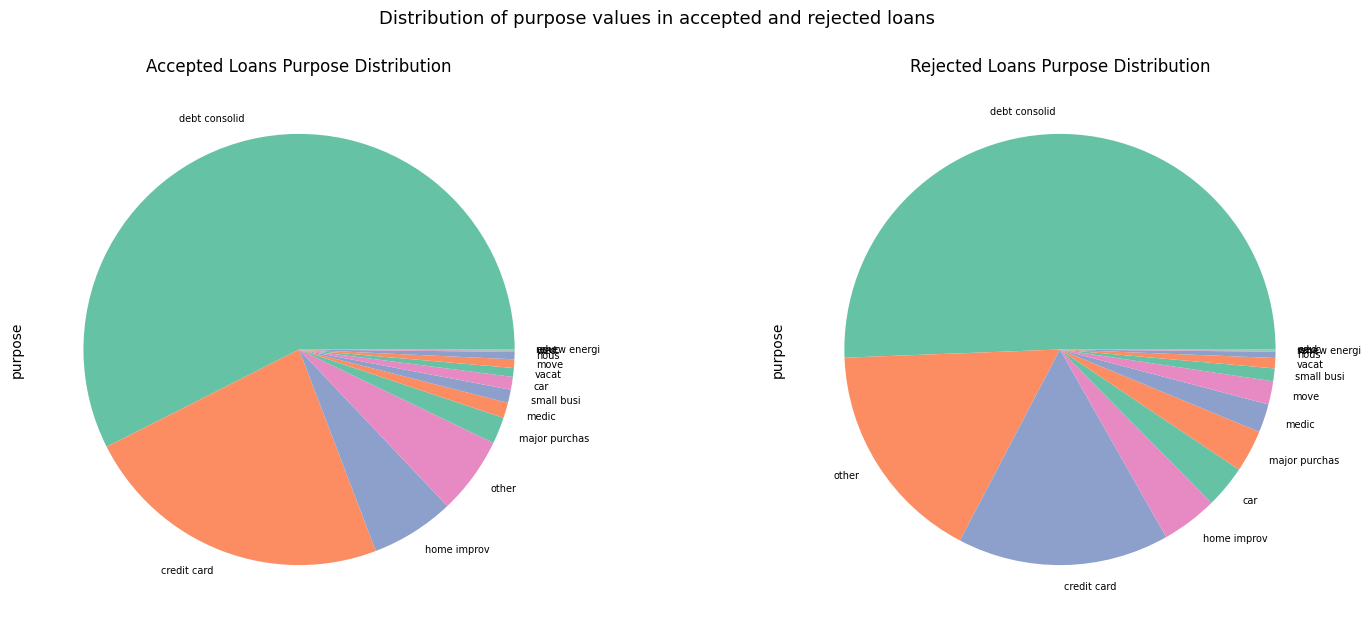

In [58]:
''' Plotting the distribution of purpose in both rejected and accepted datasets '''
helpers.plot_purpose_acc_rej(df_acc_purpose, df_rej_purpose)

#### Setting Up Final Dataframe - accepted + rejected

Now, I'll merge these two dataframes of accepted and rejected loan and create a new target variable called "status" which will be 1 if the loan is accepted and 0 if it's not.

In [59]:
''' Creating new variable where loan is accepted '''
df_accepted_step1_final = df_acc_purpose.copy()
df_accepted_step1_final['status'] = 1

In [60]:
''' Creating new variable where loan is rejected '''
df_rejected_step1_final = df_rej_purpose.copy()
df_rejected_step1_final['status'] = 0

In [61]:
''' Joining accepted and rejected loans into one dataframe '''
df_final_step1 = df_accepted_step1_final.copy()
df_final_step1 = df_final_step1.append(df_rejected_step1_final)
df_final_step1 = df_final_step1.drop_duplicates() 

We can see that we have way more rejected loans than accepted, but still there is quite a lot of data which will be used for further exploration and prediction.

In [62]:
''' Final dataset status value counts'''
df_final_step1 = df_final_step1.dropna()
df_final_step1['status'].value_counts()

0    9065365
1    1638908
Name: status, dtype: int64

### Feature Relationships Exploration

Feature relationships is important for model prediction because it can help to identify how the different features in the dataset are related to each other and to the target variable. By understanding the relationships between the features, we can gain insights into how they influence the outcome and how they can be used to improve the accuracy of the model.

First, I'll start analysing the relationship between the only continuous variables in the dataset. I took a random sample of 500000 sized sample of the dataset. I took 250000 entries of rejected and 250000 of accepted loans so that we would have equally sized classes.

In [63]:
''' Taking a 250000 entries of each class '''
df_final_step1 = helpers.stratified_sample(df_final_step1, 'status', 250000) 

We can see that there is no clear pattern between dti and loan_amnt values but I'll also perform mutual information to see its relationship bettet with the target value "status"

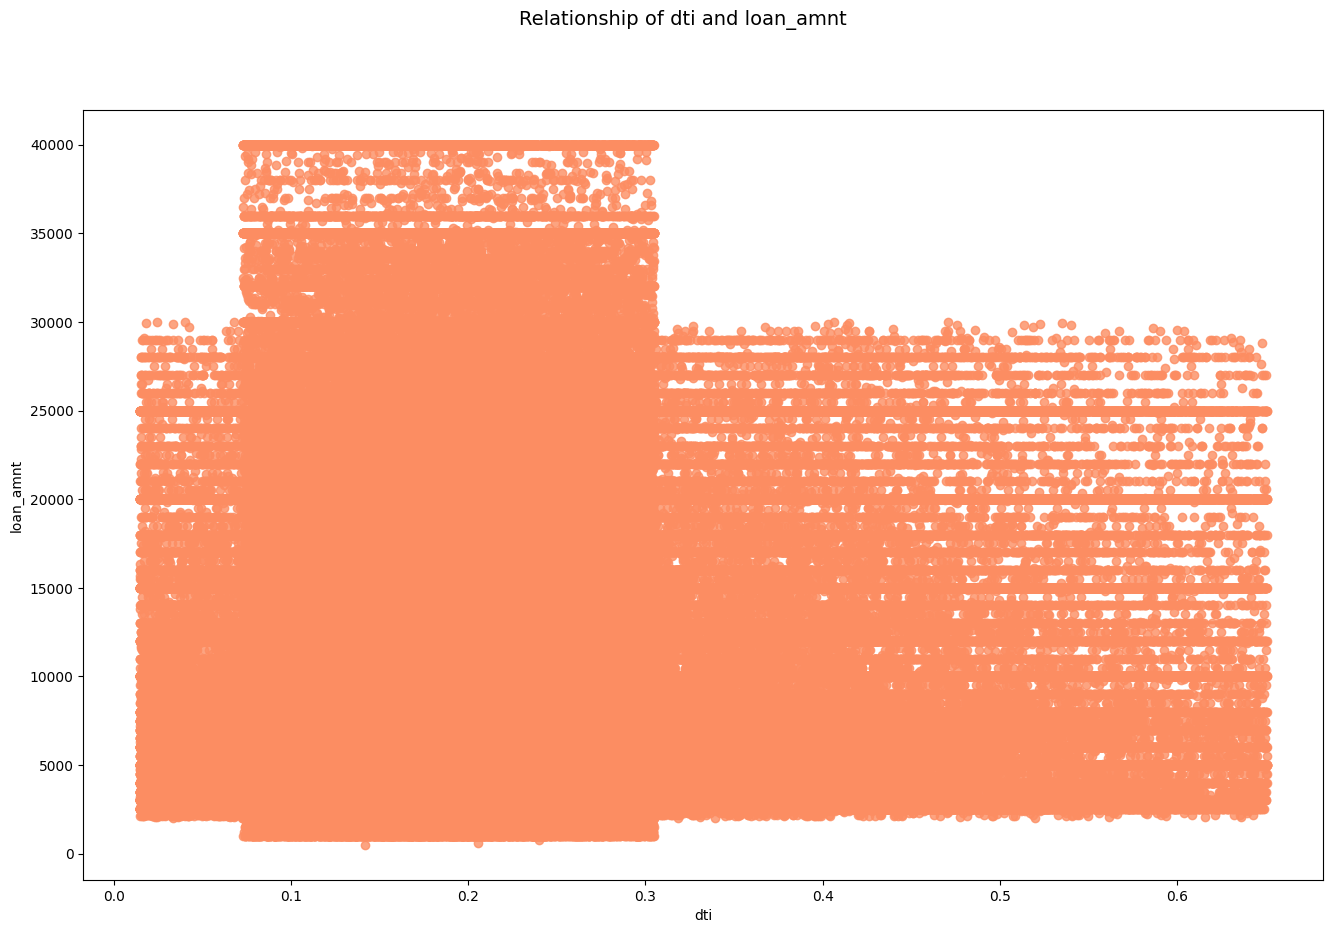

In [64]:
''' Plotting scatterplot between dti and loan_amnt '''
helpers.plot_scatter_plots(df_final_step1, 'dti', 'loan_amnt')

From the mutual information scores, we can see that the most important feature is employment length, then it's debt to income ratio and loan amount. The least important is address state, which I will not use in the prediction part.

emp_length    0.345047
dti           0.191013
loan_amnt     0.144913
purpose       0.040209
addr_state    0.010817
Name: MI Scores, dtype: float64


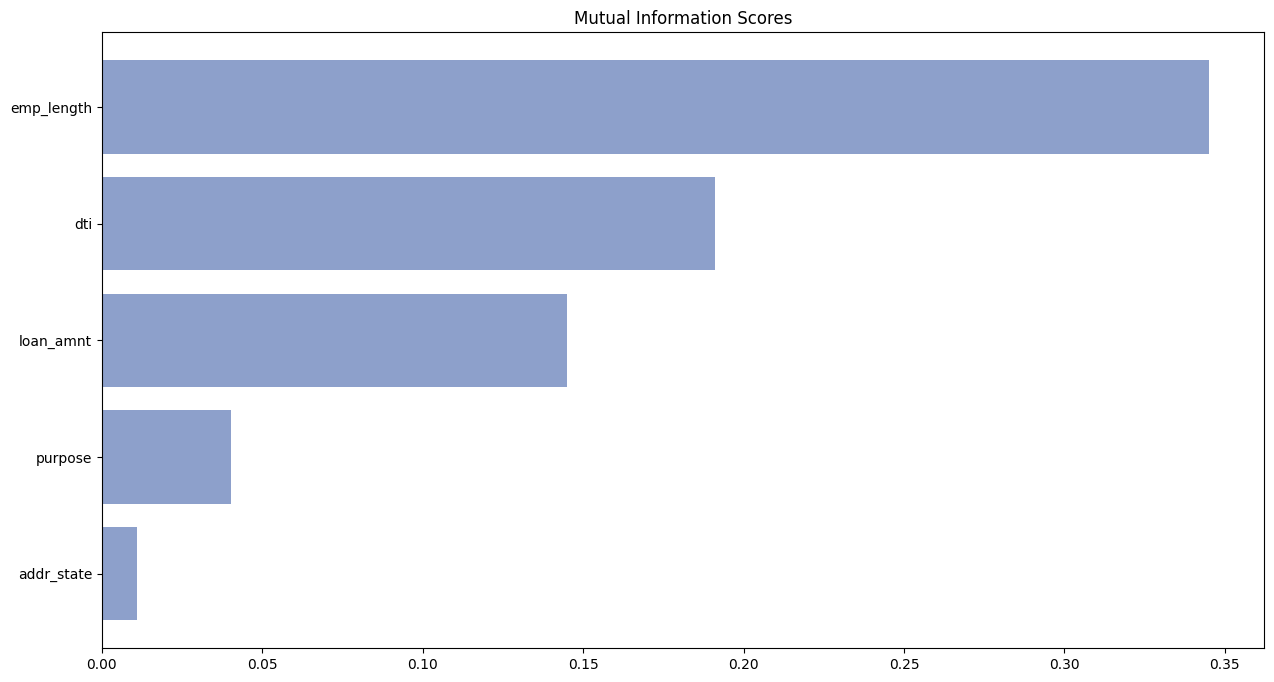

In [65]:
""" Getting mutal information values for numerical values """
mi_scores = helpers.get_and_plot_mi_scores(df_final_step1, df_final_step1[['status']], 'status')

## Loan Status Prediction

Finally, we have the final set of features. These features will be useful for prediction because of the following reasons:


* **Loan Amount**: if the loan amount is too high, it may increase the risk of default, making it less likely that the lender will approve the loan. Generally, lenders prefer to lend smaller amounts to borrowers who have a good credit history and a low risk of default.

* **Debt to Income Ratio (DTI)**: a high DTI ratio may indicate that the borrower has a high level of debt and may struggle to make the loan payments. Lenders prefer borrowers with a low DTI ratio, as it shows that the borrower has a good ability to repay the loan.

* **Employment Length**: borrowers who have been employed for a longer period of time are typically seen as more stable and less risky than those who have just started a new job. Lenders prefer borrowers who have a stable job and a reliable income stream.

* **Loan Purpose**: some loan purposes are considered riskier than others. For example, a loan to start a new business may be seen as riskier than a loan to buy a car or a home. Lenders may also have specific requirements for the purpose of the loan, such as requiring collateral for a business loan.

In [66]:
''' Setting up final list of features '''
num_cols = ['loan_amnt', 'dti']
ordinal_cols = ['emp_length']
cat_cols = ['purpose']
features = num_cols + ordinal_cols + cat_cols + ["status"] 

In [67]:
''' Separating target variable and features to predict from '''
df_step1_targets = df_final_step1[['status']].copy()
df_final_step1 = df_final_step1[features].copy()

#### Train, test, validation sets

Splitting data into training, validation, and testing sets is important to avoid overfitting, evaluate model performance, tune model parameters, and prevent data leakage. It helps ensure the model generalizes well to new, unseen data and provides an unbiased estimate of its performance.

I'll split this data into train, test and validation by stratifying it with target value "status"

In [68]:
''' Splitting dataset into train and validation '''
X_train, X_val, X_test, y_train, y_val, y_test = helpers.train_val_test_split(df_final_step1, df_step1_targets, 'status')

### Principal Component Analysis (PCA)

One of the main benefits of **PCA** is that it can reduce the number of variables in a dataset, while still capturing the most important information. This can be useful when dealing with high-dimensional data, where the number of features is large relative to the number of observations.

Therefore, I'll perform PCA for the dataset. But first, I want to extract the best number of components based on elbow plot.

The **elbow plot** is a graphical method used to determine the optimal number of principal components to use in a principal component analysis (PCA). The plot shows the proportion of variance explained by each principal component, plotted against the number of principal components.

In [69]:
''' Creating preprocessor and fitting on training data'''
preprocessor = helpers.preprocessor(num_cols, cat_cols, ordinal_cols)
X_train_transformed = preprocessor.fit_transform(X_train)

The function below calculates cumulative sum of the explained variance ratio for each principal component, which gives us the total amount of variance explained by the first n principal components.

This function gets the first principal component that explains at least 99% of the variance. It then adds 1 to this index to get the number of principal components that explain 99% of the variance. This number is saved as **n_components**.

Number of components to keep: 6


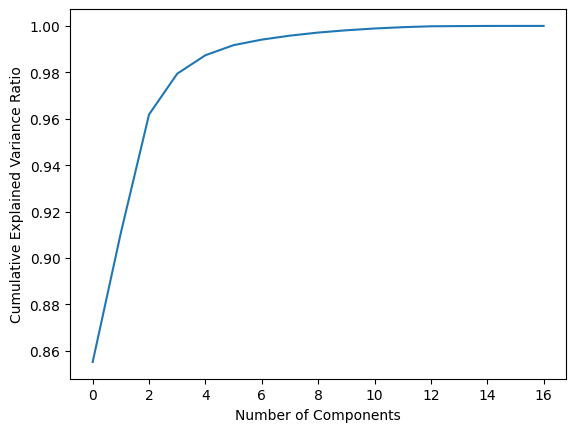

In [70]:
''' Plotting elbow plot and getting n_components'''
n_components = helpers.plot_ipca_elbow_plot_and_get_n_components(X_train_transformed, 0.99)

In [71]:
''' Getting ipca value '''
_, ipca= helpers.perform_ipca(n_components, X_train_transformed)

Explained variance ratios: [0.85524443 0.05566603 0.05095718 0.01755698 0.00794923 0.00434357]


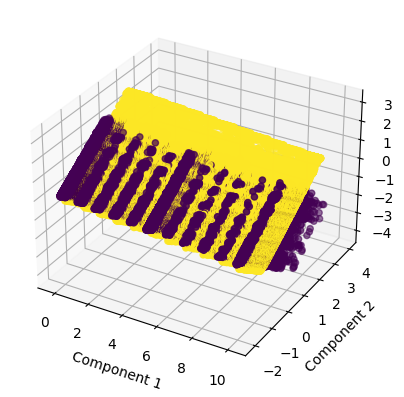

In [72]:
''' Plotting the 3 PCAs '''
helpers.plot_3_pcas(ipca, X_train_transformed, y_train)

Since, my plan is to use different types of models, I don't want to use one hot encoding for tree based models, therefore, I'll calculate the number of components for such preprocessor as well.

In [73]:
''' Creating preprocessor and fitting on training data for tree based models '''
tree_preprocessor = helpers.preprocessor(num_cols, cat_cols, ordinal_cols, 'tree')
X_train_transformed = preprocessor.fit_transform(X_train)

Number of components to keep: 6


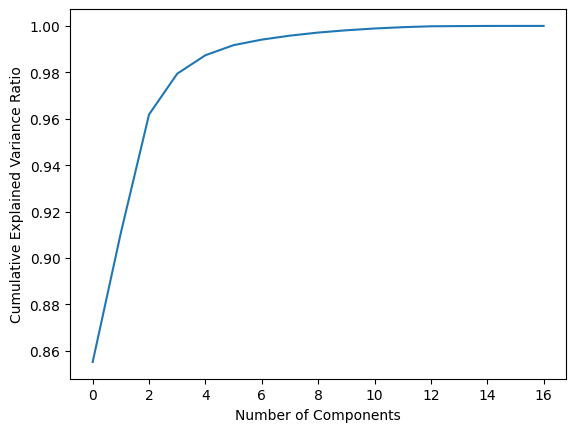

In [74]:
''' Plotting elbow plot and getting n_components for tree based models '''
n_components = helpers.plot_ipca_elbow_plot_and_get_n_components(X_train_transformed, 0.99)

In [75]:
''' Getting ipca value for tree based models '''
_, tree_ipca= helpers.perform_ipca(n_components, X_train_transformed)

Explained variance ratios: [0.85524443 0.05566603 0.05095718 0.01755698 0.00794923 0.00434357]


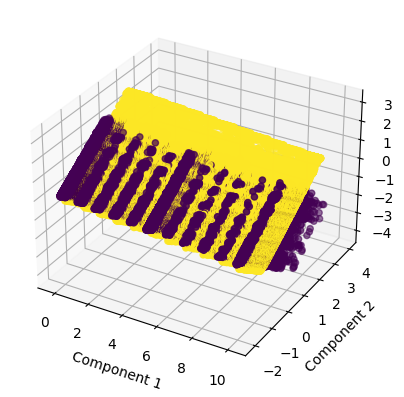

In [76]:
''' Plotting the 3 PCAs for tree based models'''
helpers.plot_3_pcas(ipca, X_train_transformed, y_train)

#### Choosing models

The F1 score is a good evaluation metric for loan acceptance/rejection prediction because it provides a balanced measure of both precision and recall.

In the context of loan acceptance/rejection prediction, precision measures the proportion of correctly predicted positive cases (i.e., loans that are predicted to be accepted and are actually accepted) among all cases predicted as positive. A high precision score indicates that the model is accurately predicting which loans will be accepted, and helps to minimize the number of false positives (i.e., loans that are predicted to be accepted but are actually rejected). This is important for lending institutions because false positives can result in financial loss.

**Choosing the F1 score as the primary evaluation metric for loan acceptance/rejection prediction can potentially save money and human power in several ways:**

* **Minimizing false positives**: A false positive occurs when a loan is predicted to be accepted, but is actually rejected. This can result in financial loss for the lending institution. By prioritizing precision (as reflected by the F1 score), the model can minimize the number of false positives, which can help to reduce financial loss and save money.

* **Reducing manual review time**: In some cases, a loan that is predicted to be rejected may actually be accepted, resulting in a false negative. In order to reduce the number of false negatives and ensure that all actual positive cases are identified, lending institutions may need to manually review loan applications. However, manually reviewing loan applications can be time-consuming and require significant human power. By using the F1 score as the primary evaluation metric, the model can identify more actual positive cases and minimize the need for manual review, which can save time and human power.

* **Improving lending decisions**: By accurately predicting loan acceptance and rejection, the model can help lending institutions to make sound lending decisions and avoid risky loans. This can help to minimize financial loss and maximize profits, which can ultimately save money and improve the overall financial health of the institution.

In summary, by using the F1 score as the primary evaluation metric for loan acceptance/rejection prediction, lending institutions can potentially save money by minimizing financial loss and reducing the need for manual review.

### Prediction

In [77]:
''' Creating list of models - tree based models and other type of models '''
tree_models = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    ExtraTreesClassifier(),
    XGBClassifier(),
    lgb.LGBMClassifier(),
    DecisionTreeClassifier()
]

other_models = [
    LogisticRegression(),  
    KNeighborsClassifier(),
    GaussianNB(),
    BernoulliNB(),
    QuadraticDiscriminantAnalysis(),
    PassiveAggressiveClassifier()
]

In [78]:
''' Creating list of pipelines with preprocessor ''' 
pipelines = helpers.getting_pipelines(tree_models, tree_preprocessor, tree_ipca, other_models, preprocessor, ipca)

First, I run the models and we can see top 5 best models.

* **XGBClassifier** with f1 score of 0.9
* **LGBMClassifier** with f1 score of 0.899
* **KNeighborsClassifier** with f1 score of 0.893
* **GradientBoostingClassifier** with f1 score of 0.892
* **RandomForestClassifier** with f1 score of 0.887

In [79]:
''' Printing out results of tested models '''
print("The best performing models are:") 
models_results = helpers.try_models(pipelines, X_train, y_train, X_val, y_val)
models_results.iloc[:, 1:]

The best performing models are:


,model_name,f1_score,recall_score,precision_score
4,XGBClassifier,0.902820,0.902825,0.902912
5,LGBMClassifier,0.901397,0.901400,0.901443
1,GradientBoostingClassifier,0.895410,0.895412,0.895449
8,KNeighborsClassifier,0.894447,0.894450,0.894488
2,AdaBoostClassifier,0.887472,0.887475,0.887513
0,RandomForestClassifier,0.881462,0.881463,0.881463
3,ExtraTreesClassifier,0.872509,0.872513,0.872549
6,DecisionTreeClassifier,0.858115,0.858137,0.858363
11,QuadraticDiscriminantAnalysis,0.817595,0.817612,0.817734
7,LogisticRegression,0.799534,0.799825,0.801578


I'll also perform **Optuna hyper parameter tuning**

Optuna is a hyperparameter optimization framework that can automatically tune hyperparameters of machine learning models. Optuna uses a technique called Bayesian optimization to explore the search space of hyperparameters and find the optimal set of values.

Optuna tuning is useful because it automates the time-consuming and often manual process of hyperparameter tuning, which can lead to significant improvements in model performance. 

In [80]:
''' Perform optuna tuning '''
results = helpers.optuna_tuning(helpers.objective, models_results.head(5).copy(), X_train, y_train, X_val, y_val) 

Tuned XGBClassifier:


,f1_score,max_depth,learning_rate,min_child_weight,subsample,colsample_bytree,gamma,alpha,lambda
0,0.902372,20,0.00114,2,0.542022,0.792756,0.271864,0.275691,0.003103


Tuned LGBMClassifier:


,f1_score,num_leaves,learning_rate,max_depth,min_child_samples,subsample,colsample_bytree
0,0.903292,218,0.151922,17,65,0.52042,0.738357


Tuned GradientBoostingClassifier:


,f1_score,max_depth,learning_rate,min_samples_split,min_samples_leaf,subsample,max_features
0,0.903055,13,0.127847,92,35,0.906366,0.98134


Tuned KNeighborsClassifier:


,f1_score
0,0.894447


Tuned AdaBoostClassifier:


,f1_score,n_estimators,learning_rate,algorithm
0,0.894462,380,0.924795,SAMME.R


In [84]:
''' Printing out top 3 models f1 scores '''
final_model_results = dict(sorted(results.items(), key=lambda item: item[1]['f1_score'], reverse=True))
dict(sorted({model[1]: result['f1_score'] for model, result in results.items()}.items(), key=lambda item: item[1], reverse=True))

{'LGBMClassifier': 0.9032916806063815,
 'GradientBoostingClassifier': 0.9030553923697633,
 'XGBClassifier': 0.9023718834664498,
 'AdaBoostClassifier': 0.8944624072423502,
 'KNeighborsClassifier': 0.8944474914786646}

In [85]:
final_top_models = [pipeline[0] for pipeline in list(final_model_results.keys())][:3]

**Cross Validation**

Comparing the results of the cross-validation with the results on the validation set is useful because it allows you to see how well the model is likely to perform on new, unseen data. If the results on the validation set are similar to the results from cross-validation, it suggests that the model is likely to generalize well to new data. If there is a large discrepancy between the two, it suggests that the model may be overfitting to the training data and not generalizing well to new data.

In [86]:
''' Getting predictions of top 3 models '''
scores, predictions = helpers.perform_cross_validation(final_top_models, X_train, y_train, X_val, y_val, score='f1_score')

------------------------- LGBMClassifier -------------------------
TRAIN DATA (cross validated) f1_score is 0.913
VALIDATION DATA - f1_score for the LGBMClassifier model is: 0.903

------------------------- GradientBoostingClassifier -------------------------
TRAIN DATA (cross validated) f1_score is 0.912
VALIDATION DATA - f1_score for the GradientBoostingClassifier model is: 0.903

------------------------- XGBClassifier -------------------------
TRAIN DATA (cross validated) f1_score is 0.913
VALIDATION DATA - f1_score for the XGBClassifier model is: 0.902



We can see that the top 3 models are performing relatively well. They are all almost identical.

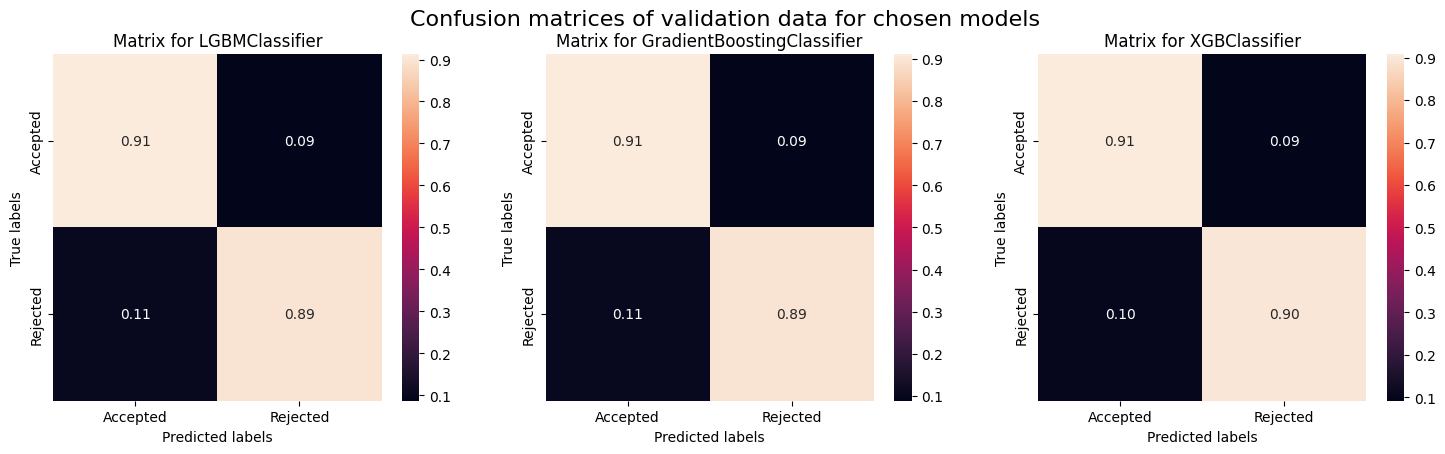

In [87]:
''' Plotting confusion matrices of top 3 models'''
helpers.plot_conf_matrices(predictions, y_val, ["Accepted", "Rejected"])

We can see the comparison between those models in ROC plot as well.

LGBMClassifier AUC for validation data 0.958403885
GradientBoostingClassifier AUC for validation data 0.9576474184375
XGBClassifier AUC for validation data 0.95706841


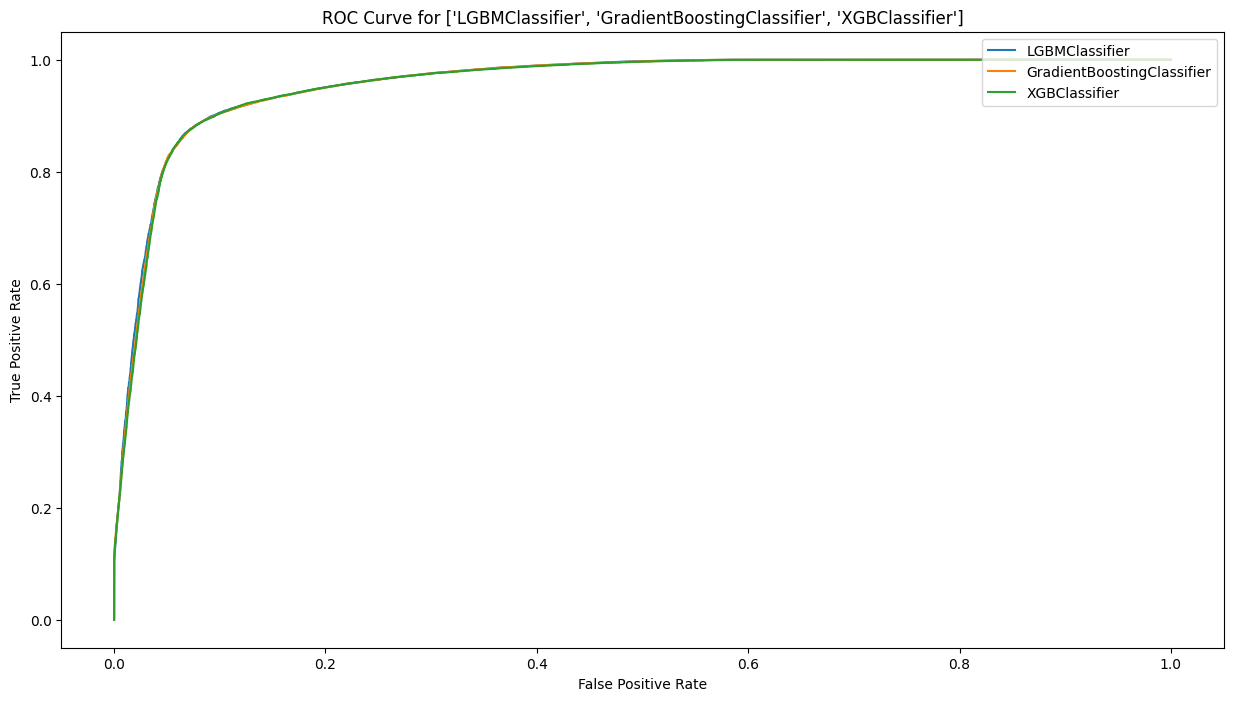

In [88]:
''' Plotting the ROC curve for final set of models '''
helpers.plot_roc(
    X_val, y_val, "validation", list(predictions.keys())
)

**Youden's J statistic** also known as the Youden index or the Youden's index, is a commonly used measure of the performance of a binary classification test. It measures the effectiveness of a binary classifier for all possible thresholds of the predicted probabilities.

Youden's J statistic is often used as the decision boundary for the classifier, as it balances the trade-off between sensitivity and specificity. A threshold that maximizes Youden's J statistic can be interpreted as the threshold that maximizes the difference between the true positive rate and the false positive rate, which is equivalent to maximizing the area under the ROC curve.

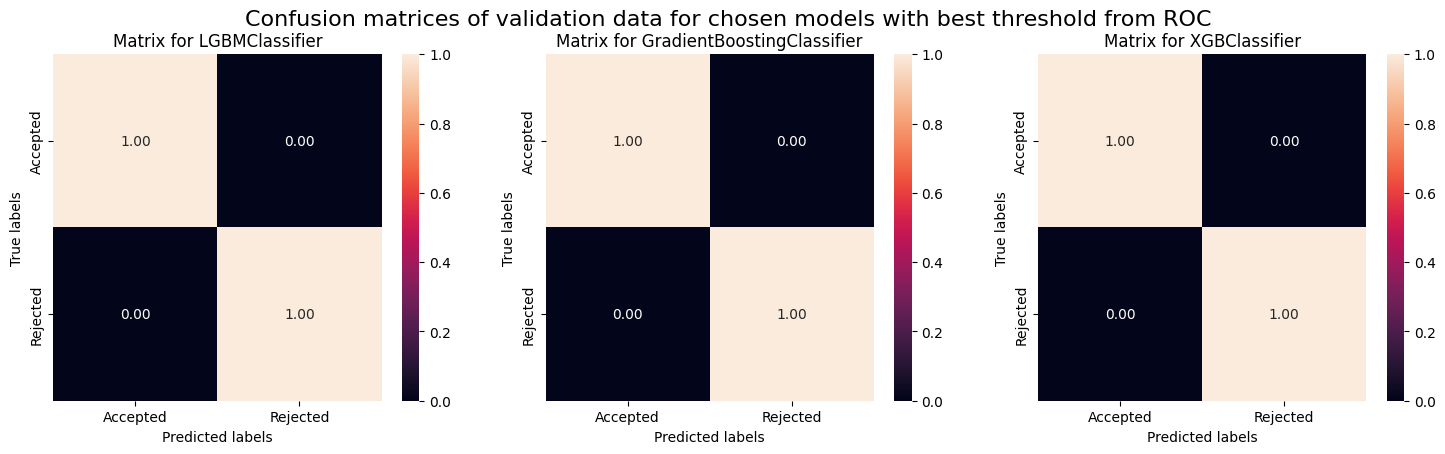

In [89]:
''' Plotting confusion matrices of top 3 models'''
# Calculate the Youden's J statistic for each threshold
helpers.plot_conf_matrices(predictions, y_val, ["Accepted", "Rejected"], roc_thres=True)

### The best model for predicting loan status - GradientBoostingClassifier
#### Deploying the model

In [90]:
''' Extracting the best model '''
best_model = list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.keys())[1]
best_model.named_steps['model']

GradientBoostingClassifier(learning_rate=0.127847117822167, max_depth=13,
                           max_features=0.9813396190765814, min_samples_leaf=35,
                           min_samples_split=92, subsample=0.9063661292459435)

In [91]:
''' Deploy model into joblib file '''
dump(best_model, "step1-status_classifier.joblib")

['step1-status_classifier.joblib']

## Step 1 - Accepted/Rejected prediction Summary

In conclusion, the prediction model developed for classifying loan applications into accepted or rejected has been effectively executed using the features '**loan_amnt**', '**dti**', '**emp_length**', and '**purpose**'. 

The dataset was balanced with 250,000 entries of each class, and a processing pipeline created effectively handled missing values, categorical variables, and dimensionality reduction. The Column Transformer employs strategies like **KNNImputer**, **SimpleImputer** and constant value imputing to manage numerical and categorical values, ensuring a clean dataset. Further, it leverages **Ordinal** and **One Hot Encoding** techniques to handle categorical columns correctly. However, for tree-based models, the pipeline uses **Ordinal Encoding** for all categorical columns to improve model performance. Lastly, Incremental PCA is employed to reduce dimensionality efficiently, optimizing the data processing and improving the overall performance of machine learning models.

Thirteen different models were tested, and the top three models — GradientBoostingClassifier, XGBoostClassifier, and LGBMClassifier — were selected for hyperparameter tuning using the Optuna module. After tuning, the GradientBoostingClassifier was identified as the best model based on its superior f1_score, but the other two contenders also showcased promising results.

The final model, GradientBoostingClassifier, has been deployed for usage by the Lending Club, providing a robust and efficient solution for their loan classification needs. This model will aid in streamlining the loan application process and improving decision-making based on the provided features, ultimately leading to better allocation of resources and increased profitability for the organization.

### Impact on Lending Club

The prediction model developed for classifying loans as accepted or rejected can be extremely helpful for the Lending Club company because it provides an efficient and reliable tool to streamline the loan decision-making process. By analyzing key features such as loan amount, debt-to-income ratio, employment length, and purpose of the loan, the model offers valuable insights to the company, significantly improving the loan evaluation process. This ultimately enhances the overall performance and profitability of the Lending Club.

## Go to next step - Step 2 & 3 - [Loan Grade and Subgrade Prediction](https://github.com/TuringCollegeSubmissions/ebaran-ML1.3/blob/master/project%20notebooks%20(step1%2C%20step2%2C%20step2%20and%20step4)/Step2_3-Grade_SubGrade.ipynb).